In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
import numpy as np
import math
from typing import Tuple

from pathlib import Path
import pickle
import datetime as dt
from datetime import datetime
from datetime import time

import matplotlib.pyplot as plt   
import seaborn as sns
from pprint import pprint

import torch
import torch.nn.functional as Funct
from torch.utils.data import Dataset, DataLoader
torch.serialization.add_safe_globals([models.DayWindowDataset])

from tqdm.auto import tqdm

import io
from PIL import Image
import IPython.display as disp

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

In [2]:
device               = params.device
ticker               = params.ticker
save_path            = params.save_path
pred_threshold       = params.pred_threshold_tick
regular_start        = params.regular_start
regular_start_pred   = params.regular_start_pred
regular_start_shifted= params.regular_start_shifted
regular_end          = params.regular_end
look_back            = params.look_back_tick
trailing_stop_thresh = params.trailing_stop_thresh_tick


In [3]:
df = pd.read_csv(params.final_csv, index_col=0, parse_dates=True)
df

,open,high,low,close,atr_14,vwap_dev,ma_20,macd_12_26,obv,hour,month,bid,ask,signal_smooth
2014-04-03 08:49:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,28.650000,0.000000,0.000000e+00,8,4,28.641405,28.658595,0.219822
2014-04-03 08:50:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,28.650000,0.000000,0.000000e+00,8,4,28.641405,28.658595,0.220376
2014-04-03 08:51:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,28.650000,0.000000,0.000000e+00,8,4,28.641405,28.658595,0.220931
2014-04-03 08:52:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,28.650000,0.000000,0.000000e+00,8,4,28.641405,28.658595,0.221487
2014-04-03 08:53:00,28.650,28.6500,28.650,28.6500,0.000000,1.240040e-16,28.650000,0.000000,0.000000e+00,8,4,28.641405,28.658595,0.222044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.375,173.6771,173.215,173.5650,0.304529,1.257638e+00,174.838390,-0.422065,4.758230e+08,20,6,173.512900,173.617100,0.002995
2025-06-18 20:57:00,173.565,173.5900,173.240,173.3800,0.317029,1.255215e+00,174.736890,-0.466939,4.751988e+08,20,6,173.328000,173.432000,0.002906
2025-06-18 20:58:00,173.390,173.4100,173.200,173.3100,0.323814,1.254293e+00,174.634390,-0.502359,4.747443e+08,20,6,173.258000,173.362000,0.005611
2025-06-18 20:59:00,173.315,173.4000,173.230,173.2800,0.322743,1.253874e+00,174.527890,-0.526778,4.736496e+08,20,6,173.228000,173.332000,0.006685


{'ATT_DROPOUT': 0.3,
 'ATT_HEADS': 8,
 'CLIPNORM': 1,
 'DROPOUT_LONG': 0.35,
 'DROPOUT_SHORT': 0.25,
 'EARLY_STOP_PATIENCE': 10,
 'ETA_MIN': 2e-05,
 'INITIAL_LR': 0.0007,
 'LONG_UNITS': 128,
 'LR_EPOCHS_WARMUP': 1,
 'MAX_EPOCHS': 60,
 'MIN_LR': 1e-06,
 'NUM_WORKERS': 2,
 'PLATEAU_FACTOR': 0.9,
 'PLATEAU_PATIENCE': 0,
 'PLAT_EPOCHS_WARMUP': 999,
 'SHORT_UNITS': 64,
 'TRAIN_BATCH': 32,
 'TRAIN_PREFETCH_FACTOR': 1,
 'T_0': 60,
 'T_MULT': 1,
 'VAL_BATCH': 1,
 'WEIGHT_DECAY': 0.0001}


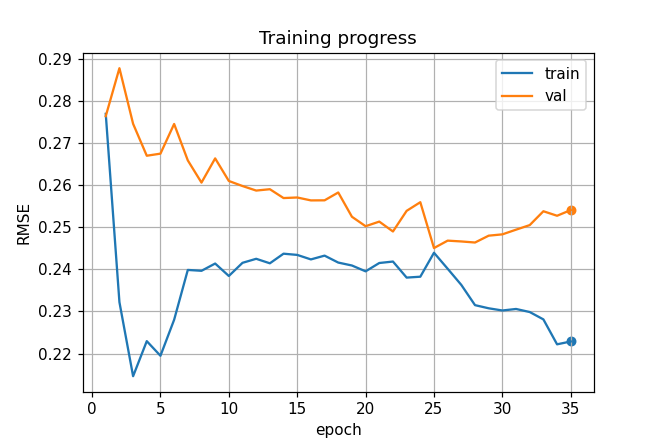

DualMemoryLSTM(
  (short_lstm): LSTM(11, 64, batch_first=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (do_short): Dropout(p=0.22954890576005055, inplace=False)
  (ln_short): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(64, 128, batch_first=True)
  (do_long): Dropout(p=0.343468190413778, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
)

In [4]:
# Load the entire model object (architecture + weights)# 1) load your checkpoint dict
ckpt = torch.load(params.model_path, map_location=device, weights_only=False)

# 2) grab the full model object you saved
model_best = ckpt["model_obj"]

# 3) move to device and set eval mode
model_best = model_best.to(device).eval()

# 4) show parameters, training plot, and model
saved_hparams = ckpt["hparams"]
pprint(saved_hparams)

png_bytes = ckpt.get("train_plot_png")
img = Image.open(io.BytesIO(png_bytes))
disp.display(img)

model_best


In [5]:
print('executing <build_lstm_tensors>...')
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df=df,
    look_back=look_back,
    features_cols=params.features_cols,
    label_col=params.label_col,
    regular_start=regular_start_pred 
)

print('executing <chronological_split>...')
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df,
    look_back    = look_back,
    regular_start=regular_start_pred, 
    train_prop   = params.train_prop,
    val_prop     = params.val_prop,
    train_batch  = params.hparams['TRAIN_BATCH']
)

print('executing <split_to_day_datasets>...')
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS']
)

print('dataloaders generated!')

executing <build_lstm_tensors>...
executing <chronological_split>...
executing <split_to_day_datasets>...
▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=1132845, val=236394, te=240962
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..413], total days=414
   te_day_id  ∈ [0..421], total days=422
4) instantiating DayWindowDatasets
   ds_tr days: 1984
   ds_val days: 414
   ds_te days: 422
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready
dataloaders generated!


In [6]:
# zero‐forecast baseline on val vs test
# √( mean( (yᵢ – 0)² ) )

val_baseline  = models.naive_rmse(val_loader)
test_baseline = models.naive_rmse(test_loader)

print(f"Val zero‐forecast baseline RMSE  = {val_baseline:.5f}")
print(f"Test zero‐forecast baseline RMSE = {test_baseline:.5f}")

Val zero‐forecast baseline RMSE  = 0.51801
Test zero‐forecast baseline RMSE = 0.55302


std val: 0.32973263
std test: 0.34039408


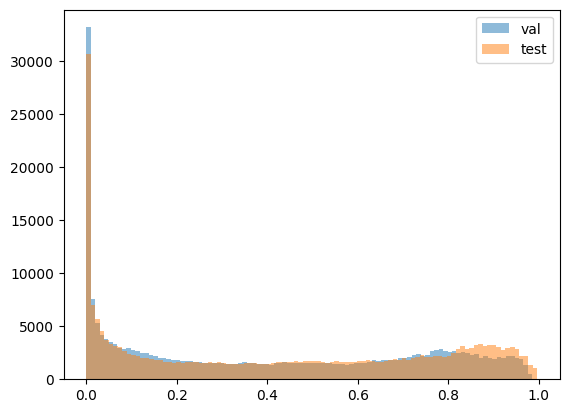

In [7]:
# to confirm the baseline proportions, calculate the STD
# σ = √( mean( (yᵢ – ȳ)² ) )

y_vals = np.concatenate([batch[1].view(-1).numpy()
                         for batch in val_loader])
y_tes  = np.concatenate([batch[1].view(-1).numpy()
                         for batch in test_loader])
print("std val:", np.std(y_vals))
print("std test:", np.std(y_tes))

plt.hist(y_vals, bins=100, alpha=0.5, label="val")
plt.hist(y_tes,  bins=100, alpha=0.5, label="test")
plt.legend(); plt.show()

In [8]:
def evaluate_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    split_name: str
) -> Tuple[float, np.ndarray]:
    """
    Fast per-day RMSE + preds, exactly matching  val‐phase logic:

    • Expects each batch from `loader` to be a tuple of at least
      (xb_batch, yb_batch, day_id_batch, …). We only use the first 3.
    • xb_batch: Tensor(B, W, look_back, F)
    • yb_batch: Tensor(B, W)
    • day_id_batch: Tensor(B,) or (B, W) weekday/day‐id
    """

    model.to(device).eval()
    model.h_short = model.h_long = None

    prev_day_id   = None
    total_sq_err  = 0.0
    total_windows = 0
    all_preds     = []

    with torch.no_grad():
        for batch in tqdm(loader, desc=split_name, unit="batch"):
            # grab only the first three outputs, ignore raw_close/raw_bid/etc.
            xb_batch, yb_batch, day_id_batch = batch[:3]

            # move to device once
            xb_batch     = xb_batch.to(device, non_blocking=True)
            yb_batch     = yb_batch.to(device, non_blocking=True)
            day_id_batch = day_id_batch.to(device, non_blocking=True)

            # if we got one day_id per window, reduce to one/day
            if day_id_batch.dim() > 1:
                day_id_batch = day_id_batch[:, 0]

            B, W = xb_batch.shape[0], xb_batch.shape[1]

            for i in range(B):
                x_day  = xb_batch[i]             # (W, look_back, F)
                y_day  = yb_batch[i].view(-1)    # (W,)
                day_id = int(day_id_batch[i].item())

                # reset LSTM states exactly as in val loop
                model.reset_short()
                if prev_day_id is not None and day_id < prev_day_id:
                    model.reset_long()
                prev_day_id = day_id

                out      = model(x_day)          # (W, look_back, 1)
                pred_day = out[:, -1, 0]         # (W,)

                total_sq_err  += (pred_day - y_day).pow(2).sum().item()
                total_windows += y_day.numel()
                all_preds.append(pred_day.cpu().numpy())

    rmse  = math.sqrt(total_sq_err / total_windows)
    preds = np.concatenate(all_preds, axis=0)

    print(f"\n{split_name} RMSE over {total_windows} windows = {rmse:.5f}")
    return rmse, preds


In [9]:
train_rmse, train_preds = evaluate_model(
    model_best, train_loader, device,
    split_name="Train"
)
val_rmse, val_preds     = evaluate_model(
    model_best, val_loader,   device,
    split_name="Validation"
)
test_rmse, test_preds   = evaluate_model(
    model_best, test_loader,  device,
    split_name="Test"
)

print("Train preds:", len(train_preds))
print("Val   preds:", len(val_preds))
print("Test  preds:", len(test_preds))

Train:   0%|          | 0/62 [00:00<?, ?batch/s]


Train RMSE over 1132864 windows = 0.26954


Validation:   0%|          | 0/414 [00:00<?, ?batch/s]


Validation RMSE over 236394 windows = 0.25409


Test:   0%|          | 0/422 [00:00<?, ?batch/s]


Test RMSE over 240962 windows = 0.28541
Train preds: 1132864
Val   preds: 236394
Test  preds: 240962


In [10]:
def add_pred_and_split(
    df: pd.DataFrame,
    train_preds: np.ndarray,
    val_preds: np.ndarray,
    test_preds: np.ndarray,
    day_id_tr: np.ndarray,
    day_id_val: np.ndarray,
    day_id_te: np.ndarray
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Stamp pred_signal for every bar from regular_start_pred onward,
    then simulate actions from regular_start
    """

    # 1) Prepare the output DataFrame
    df_out = df.copy()
    df_out["pred_signal"] = np.nan
    df_out["pred_action"] = 0

    # 2) Map day-id arrays → calendar dates
    all_days = sorted(df_out.index.normalize().unique())
    tr_days  = [all_days[i] for i in np.unique(day_id_tr).astype(int)]
    val_days = [all_days[i] for i in np.unique(day_id_val).astype(int)]
    te_days  = [all_days[i] for i in np.unique(day_id_te).astype(int)]

    # 3) Generic function to stamp preds on each split
    def stamp_split(days, preds, name):
        mask = (
            df_out.index.normalize().isin(days)
            & (df_out.index.time >= regular_start_pred)
        )
        idx = df_out.loc[mask].index
        if len(idx) != len(preds):
            raise ValueError(
                f"{name}: expected {len(idx)} slots, got {len(preds)} preds"
            )
        df_out.loc[idx, "pred_signal"] = preds

    # 4) Stamp Train, Val, Test
    stamp_split(tr_days, train_preds, name="Train")
    stamp_split(val_days, val_preds,   name="Val")
    stamp_split(te_days,  test_preds,  name="Test")

    train_val_days = set(tr_days + val_days)
    df_train_val  = df_out[df_out.index.normalize().isin(train_val_days)].copy()
    df_test       = df_out[df_out.index.normalize().isin(te_days)].copy()

    return df_train_val, train_val_days, df_test, te_days


In [11]:
df_train_val, train_val_days, df_test, te_days = add_pred_and_split(
                                                                    df=df, 
                                                                    train_preds=train_preds,
                                                                    val_preds=val_preds,
                                                                    test_preds=test_preds, 
                                                                    day_id_tr=day_id_tr,
                                                                    day_id_val=day_id_val,
                                                                    day_id_te=day_id_te
                                                                    )

df_train_val

,open,high,low,close,atr_14,vwap_dev,ma_20,macd_12_26,obv,hour,month,bid,ask,signal_smooth,pred_signal,pred_action
2014-04-03 08:49:00,28.650,28.65,28.650,28.650,0.000000,1.240040e-16,28.65000,0.000000,0.000000e+00,8,4,28.641405,28.658595,0.219822,NaN,0
2014-04-03 08:50:00,28.650,28.65,28.650,28.650,0.000000,1.240040e-16,28.65000,0.000000,0.000000e+00,8,4,28.641405,28.658595,0.220376,NaN,0
2014-04-03 08:51:00,28.650,28.65,28.650,28.650,0.000000,1.240040e-16,28.65000,0.000000,0.000000e+00,8,4,28.641405,28.658595,0.220931,NaN,0
2014-04-03 08:52:00,28.650,28.65,28.650,28.650,0.000000,1.240040e-16,28.65000,0.000000,0.000000e+00,8,4,28.641405,28.658595,0.221487,NaN,0
2014-04-03 08:53:00,28.650,28.65,28.650,28.650,0.000000,1.240040e-16,28.65000,0.000000,0.000000e+00,8,4,28.641405,28.658595,0.222044,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-11 20:56:00,140.510,140.62,140.505,140.610,0.105893,1.166374e+00,140.52549,0.040273,4.742212e+08,20,10,140.567800,140.652200,0.000000,0.264903,0
2023-10-11 20:57:00,140.610,140.66,140.530,140.550,0.112493,1.165446e+00,140.53499,0.038238,4.740805e+08,20,10,140.507800,140.592200,0.000000,0.264527,0
2023-10-11 20:58:00,140.550,140.60,140.530,140.585,0.111071,1.165982e+00,140.54474,0.039000,4.742260e+08,20,10,140.542800,140.627200,0.000000,0.264571,0
2023-10-11 20:59:00,140.580,140.62,140.520,140.565,0.112571,1.165662e+00,140.54949,0.037557,4.738080e+08,20,10,140.522800,140.607200,0.000000,0.264390,0


In [12]:
def objective(trial):
    
    print('1) Suggest hyperparameters')
    pred_threshold       = trial.suggest_float(
        "pred_threshold",  0.03, 0.66    # example range
    )
    trailing_stop_pred = trial.suggest_float(
        "trailing_stop_pred", 0.001, 0.05  # example range
    )
    
    print('2) Copy the DataFrame & reset actions')
    df_tmp = df_train_val.copy()
    df_tmp["pred_action"] = 0

    print('3) Generate actions per day')
    for day in train_val_days:
        day_slice = df_tmp[df_tmp.index.normalize() == day]
        day_actions = trades.generate_trade_actions(
            df=day_slice,
            col_signal="pred_signal",
            col_action="pred_action",
            buy_threshold=pred_threshold,
            trailing_stop_thresh=trailing_stop_pred,
            regular_start=params.regular_start
        )
        df_tmp.loc[day_actions.index, "pred_action"] = (
            day_actions["pred_action"].fillna(0).astype(int)
        )

    print('4) Simulate P&L')
    sim_results = trades.simulate_trading(
        results_by_day_sign=df_tmp,
        col_action="pred_action",
        regular_start=params.regular_start,
        regular_end=params.regular_end,
        ticker=params.ticker
    )

    print('5) Compute average daily P&L')
    daily_returns = [
        stats["Strategy Return ($)"]
        for _, (_, _, stats) in sim_results.items()
    ]
    total_pnl = float(np.sum(daily_returns))
    num_days = len(train_val_days)
    avg_daily_pnl = total_pnl / num_days if num_days else 0.0

    print('6) Report to Optuna (maximize P&L)')

    # report & cleanup
    print(f"→ Total P&L across {num_days} days: ${total_pnl:.2f}")
    print(f"→ Average daily P&L         : ${avg_daily_pnl:.4f}\n")
    
    return avg_daily_pnl


[I 2025-08-01 20:19:49,257] A new study created in RDB with name: no-name-e0ccb23c-4427-4a74-9c91-f4e99c715307


1) Suggest hyperparameters
2) Copy the DataFrame & reset actions
3) Generate actions per day
4) Simulate P&L


[I 2025-08-01 20:21:29,802] Trial 0 finished with value: 0.4400391993327773 and parameters: {'pred_threshold': 0.2908705384712167, 'trailing_stop_pred': 0.024494023837260268}. Best is trial 0 with value: 0.4400391993327773.


5) Compute average daily P&L
6) Report to Optuna (maximize P&L)
→ Total P&L across 2398 days: $1055.21
→ Average daily P&L         : $0.4400



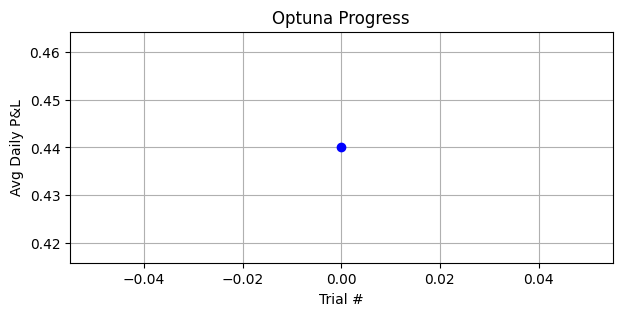

1) Suggest hyperparameters
2) Copy the DataFrame & reset actions
3) Generate actions per day
4) Simulate P&L


In [ ]:
# === 1) Create & Run the Optuna Study ===
n_trials = 100      # adjust as needed
n_jobs   = 1       # set >1 for parallel trials

pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)
study  = optuna.create_study(
    storage="sqlite:///optuna_study.db",
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,
    callbacks=[plots.cleanup_callback, plots.lightweight_plot_callback],
    gc_after_trial=True
)

# === 2) Final Visualization & Results ===
fig = plot_optimization_history(study)
fig.set_size_inches(8, 4)
fig.axes[0].set_title("Optuna Optimization History")
plt.show()

print("Best Parameters       :", study.best_params)
print("Best Average Daily P&L:", study.best_value)

# === 3) Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# === 4) Save Study to JSON ===
results_folder = params.optuna_folder

session_df = df.between_time(params.regular_start, params.regular_end)
first_day  = session_df.index.normalize().min()
last_day   = session_df.index.normalize().max()
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{params.ticker}_{start_date}-{end_date}_optuna_predsig_pars.json"
file_path  = os.path.join(results_folder, file_name)

with open(file_path, "w") as f:
    json.dump({
        "best_params": study.best_params,
        "best_value" : study.best_value,
        "importances": importances,
        "trials": [
            {
                "number": t.number,
                "value":  t.value,
                "params": t.params,
                "state":  t.state.name
            }
            for t in study.trials
        ],
    }, f, indent=4)

print(f"\nOptuna results (and importances) saved to: {file_path}")

In [ ]:
.

In [ ]:
# Compute Descriptive Statistics
# Statistics show whether your model systematically over/under-estimates (compare means) and how tightly it tracks (std & correlation).

# assume df is your DataFrame
stats = df_test[['signal_smooth','pred_signal']].describe().T

# add range and error
stats['range'] = stats['max'] - stats['min']
corr = df_test['signal_smooth'].corr(df_test['pred_signal'])
stats['pearson_r_with_other'] = [corr, corr]

print(stats)

In [ ]:
# Distribution Overlay
# Histogram overlay reveals any bias or mismatched shape in the two distributions.

plt.figure(figsize=(8,4))
sns.histplot(df_test['signal_smooth'], color='C0', alpha=0.5, bins=50, label='signal_smooth')
sns.histplot(df_test['pred_signal'],   color='C1', alpha=0.5, bins=50, label='pred_signal')
plt.legend()
plt.xlabel('Signal Value')
plt.ylabel('Count')
plt.title('Histogram of signal_smooth vs. pred_signal')
plt.show()

In [ ]:
# Scatter Plot: Relationship
# Scatter against the 45° line instantly shows under/over‐prediction regions and non‐linear errors.

plt.figure(figsize=(5,5))
plt.scatter(df_test['signal_smooth'], df_test['pred_signal'],
            s=5, alpha=0.3, color='C2')
plt.plot([0,1],[0,1], 'k--', linewidth=1)  # 45° reference line
plt.xlabel('signal_smooth')
plt.ylabel('pred_signal')
plt.title('pred_signal vs. signal_smooth')
plt.axis('equal')
plt.show()

In [ ]:
# Time-Series Comparison (Sample)
# Time‐series plots let you see if the model lags or leads the smoothed signal on a given day.

# pick a single day or time span
day = df_test.index.normalize().unique()[-1]
mask = df_test.index.normalize() == day

plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'signal_smooth'], label='signal_smooth')
plt.plot(df_test.index[mask], df_test.loc[mask,'pred_signal'],   label='pred_signal')
plt.legend(loc='upper left')
plt.title(f'Signals on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Error Analysis 
# Error plots quantify where and when the model struggles most, guiding you to fix lag, amplitude scaling, or threshold issues.

# create error column
df_test['error'] = df_test['pred_signal'] - df_test['signal_smooth']

# Distribution of prediction error
plt.figure(figsize=(6,3))
sns.histplot(df_test['error'], bins=50, color='C3', kde=True)
plt.xlabel('Prediction Error')
plt.title('Error Distribution: pred_signal − signal_smooth')
plt.show()

# Time evolution of error on that same sample day
plt.figure(figsize=(10,3))
plt.plot(df_test.index[mask], df_test.loc[mask,'error'], color='C4')
plt.axhline(0, color='k', linestyle='--', linewidth=1)
plt.title(f'Prediction Error over time on {day.date()}')
plt.xlabel('Time')
plt.ylabel('Error')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
print('generating sim_results as a dict: { date → (df_sim, trades_list, perf_stats) } ...')

# Run the simulator on your DataFrame of predictions/actions
sim_results = trades.simulate_trading(
    results_by_day_sign = df_train_val,              # DF with pred_action
    col_action          = "pred_action",              # name of the discrete action column
    regular_start       = params.regular_start,   
    regular_end         = params.regular_end,         
    ticker              = params.ticker
)


In [ ]:
importlib.reload(params)
# month to inspect (YYYY-MM)
date_to_test = params.date_to_test

year, month = map(int, date_to_test.split("-"))

# 1) Build lists of days in that month + accumulate ALL days
days_in_month = []
performance_month = []
performance_all   = []

for day, (df_sim, trades_list, perf_stats) in sim_results.items():
    # always collect for the global summary
    performance_all.append(perf_stats)

    # pick out this month for plotting
    if day.year == year and day.month == month:
        days_in_month.append(day)
        performance_month.append(perf_stats)

# 2) Plot & print per-day stats for the month
if not days_in_month:
    print(f"No simulation data for {date_to_test}")
else:
    print(f"\nPlotting days in {date_to_test}:")
    for day in days_in_month:
        df_sim, trades_list, perf_stats = sim_results[day]
        plots.plot_trades(
            df                = df_sim,
            col_signal1       = "pred_signal",
            col_signal2       = "signal_smooth",
            col_action        = "pred_action",
            trades            = trades_list,
            buy_threshold     = params.pred_threshold_tick,
            performance_stats = perf_stats
        )
        
        print(f"\n=== Performance for {day} ===")
        for k, v in perf_stats.items():
            print(f"{k}: {v}")

# 3) Monthly summary
df_month = df_test[df_test.index.to_period("M") == date_to_test]
monthly_summary = plots.aggregate_performance(performance_month, df_month)
pprint(monthly_summary)

# 4) Overall summary across ALL days, with date range
overall_summary = plots.aggregate_performance(performance_all, df_test)
pprint(overall_summary)
